# Replicating Goyal and Welch (2008, RFS)

This Notebook replicates the annual analyses in Goyal and Welch (2008, RFS).


***Abstract:***

*Our article comprehensively reexamines the performance of variables that have been suggested by the academic literature to be good predictors of the equity premium. We find that by and large, these models have predicted poorly both in-sample (IS) and out-of-sample (OOS) for 30 years now; these models seem unstable, as diagnosed by their out-of-sample predictions and other statistics; and these models would not have helped an investor with access only to available information to profitably time the market.*

In [1]:
# Required packages

import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas.tseries.offsets import MonthEnd

%matplotlib inline

### 1. $\quad$ Data

The PredictorData.xls file can be downloaded from Amit Goyal's website:

https://docs.google.com/spreadsheets/d/1bM7vCWd3WOt95Sf9qjLPZjoiafgF_8EG/edit?gid=407859737#gid=407859737$


#### 1.1. $\quad$ Import the data

We then import the data.

In [2]:
xls_path = 'PredictorData2023.xlsx'

goyal = pd.ExcelFile(xls_path)
df = {sheet_name: goyal.parse(sheet_name) for sheet_name in goyal.sheet_names}

/Users/justincase/PycharmProjects/FIN710/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/FIN710/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/FIN710/.venv/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


#### 1.2. $\quad$ Data pre-processing

Equity premium prediction is a time series forecasting task. 

Let's start by creating datetime indices for the monthly and annual data.

In [3]:
# create date index for monthly data
df['Monthly']['yyyymm'] = pd.to_datetime(df['Monthly']['yyyymm'].astype(str), format='%Y%m')
df['Monthly'].set_index('yyyymm', inplace=True)
df['Monthly'].index = df['Monthly'].index.to_period('M').to_timestamp('M')


# create date index for annual data
df['Annual']['yyyy'] = pd.to_datetime(df['Annual']['yyyy'].astype(str), format='%Y')
df['Annual'].set_index('yyyy', inplace=True)
df['Annual'].index = df['Annual'].index.to_period('Y').to_timestamp('Y')

df = df['Annual']

df.head()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,ntis,Rfree,infl,eqis,ltr,corpr,svar,csp,ik,CRSP_SPvw,CRSP_SPvwx
yyyy,,,,,,,,,,,,,,,,,,,,
1871-12-31,4.74,0.26,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1872-12-31,5.07,0.30,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1873-12-31,4.42,0.33,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1874-12-31,4.54,0.33,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1875-12-31,4.37,0.30,0.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can then create the predictor variables and target variable, as described in Goyal and Welch.

In [4]:
# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices.
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated corporate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
df['dfr'] = df['corpr'] - df['ltr']

# Calculate Index Price plus Dividends
df['IndexDiv'] = df['Index'] + df['D12']

# Calculate logretdiv (log return with dividends)
df['logretdiv'] = np.log(df['IndexDiv'] / df['Index'].shift(1))

# Calculate logRfree
df['logRfree'] = np.log(df['Rfree'] + 1)

# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['logretdiv'] - df['logRfree']

df = df.drop(columns=['Index', 'csp', 'D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

df.head()

,b/m,tbl,lty,cay,ntis,infl,eqis,ltr,svar,ik,...,d/y,e/p,d/e,tms,dfy,dfr,IndexDiv,logretdiv,logRfree,premium
yyyy,,,,,,,,,,,,,,,,,,,,,
1871-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.472328,-0.430783,NaN,NaN,NaN,5.00,NaN,0.048419,NaN
1872-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.760010,-2.467311,-0.360003,NaN,NaN,NaN,5.37,0.124791,0.071515,0.053276
1873-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.732003,-2.262668,-0.332134,NaN,NaN,NaN,4.75,-0.065196,0.087750,-0.152946
1874-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.594802,-2.289456,-0.332134,NaN,NaN,NaN,4.87,0.096954,0.056677,0.040277
1875-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.716900,-2.496414,-0.182322,NaN,NaN,NaN,4.67,0.028232,0.044875,-0.016643


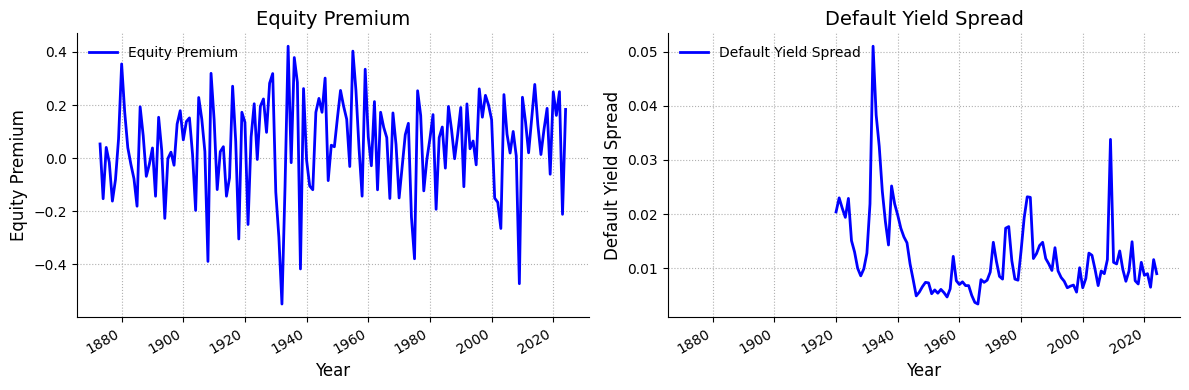

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(12, 4),
    sharex=True
)

for ax, col, title in [
    (ax1, 'premium',          'Equity Premium'),
    (ax2, 'dfy',              'Default Yield Spread')
]:
    # thicker, simpler line
    ax.plot(df.index, df[col],
            color='blue', linewidth=2, label=title)

    # titles & labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Year',   fontsize=12)
    ax.set_ylabel(title,     fontsize=12)

    # light dotted grid
    ax.grid(True, linestyle=':')

    # legend with no frame
    ax.legend(loc='upper left', frameon=False, fontsize=10)

    # remove top & right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# rotate & align date labels
fig.autofmt_xdate()

fig.tight_layout()
plt.show()


# Display the plot
plt.show()

### 2. $\quad$ Defining the model

Let's replicate the analysis performed in Goyal and Welch (2008, RFS).

In [6]:
def get_statistics(ts_df, indep, dep, h=1, start='1872-12-31', end='2004-12-31', est_periods_OOS=20):

    #### IS ANALYSIS

    # 1. Historical mean model
    avg = ts_df.loc[start:end, dep].mean()
    IS_error_N = ts_df.loc[start:end, dep] - avg

    # 2. OLS model
    ts_df['lag_indep'] = ts_df[indep].shift(1)
    reg = sm.OLS(ts_df.loc[start:end, dep], sm.add_constant(ts_df.loc[start:end, 'lag_indep'])).fit()
    IS_error_A = reg.resid

    #### OOS ANALYSIS
    OOS_error_N = np.zeros(len(ts_df.loc[start:end]) - est_periods_OOS)
    OOS_error_A = np.zeros(len(ts_df.loc[start:end]) - est_periods_OOS)

    date_index = pd.to_datetime(ts_df.index)
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    j = 0

    for current_date in date_index[(date_index >= start_date + pd.DateOffset(years=est_periods_OOS)) & (date_index < end_date)]:

        next_date = current_date + pd.DateOffset(years=1) + MonthEnd(0)
        actual_ERP = ts_df.loc[next_date, dep]

        # 1. Historical mean model
        historical_data = ts_df.loc[start:current_date, dep]
        OOS_error_N[j - 1] = actual_ERP - historical_data.mean()

        # 2. OLS model
        reg_OOS = sm.OLS(ts_df.loc[start:current_date, dep],
                         sm.add_constant(ts_df.loc[start:current_date,
                                         'lag_indep'])).fit()
        # Prepare the prediction DataFrame
        indep_values = ts_df.loc[[current_date], [indep]]
        indep_values = sm.add_constant(indep_values, has_constant='add')

        pred_ERP = reg_OOS.predict(indep_values)
        OOS_error_A[j - 1] = pred_ERP - actual_ERP

        j += 1
        if j>=len(OOS_error_N):
            break

    # Compute statistics
    MSE_N = np.mean(OOS_error_N**2)
    MSE_A = np.mean(OOS_error_A**2)
    T = len(ts_df[dep].dropna())
    OOS_R2 = 1 - MSE_A / MSE_N
    OOS_oR2 = OOS_R2 - (1 - OOS_R2) * (reg.df_resid / (T - 1))
    dRMSE = np.sqrt(MSE_N) - np.sqrt(MSE_A)

    #### CREATE PLOT
    IS = np.cumsum(IS_error_N[0:]**2) - np.cumsum(IS_error_A**2)
    OOS = np.cumsum(OOS_error_N**2)   - np.cumsum(OOS_error_A**2)

    x_range = date_index[
        (date_index >= start_date + pd.DateOffset(years=est_periods_OOS))
      & (date_index <= end_date)
    ]

    df_plot = pd.DataFrame({
        'x':   x_range,
        'IS':  IS[est_periods_OOS:],
        'OOS': OOS
    })
    # re-base your IS curve at zero
    df_plot['IS'] -= df_plot['IS'].iloc[0]

    # --- add lower/upper for the IS confidence band ---
    band = 0.015
    df_plot['lower'] = df_plot['OOS'] - band
    df_plot['upper'] = df_plot['OOS'] + band

    # now melt, keeping lower/upper around
    df_melted = df_plot.melt(
        id_vars    = ['x','lower','upper'],
        var_name   = 'variable',
        value_name = 'value'
    )


    fig, ax = plt.subplots(figsize=(7, 4))

    #–– 1) draw the purple top‐&‐bottom margin bands ––
    ymin, ymax = -0.2, 0.2
    ax.axhspan(ymax,   ymax + 0.02, color='lavender', alpha=0.7, zorder=0)
    ax.axhspan(ymin-0.02, ymin,   color='lavender', alpha=0.7, zorder=0)

    #–– 2) plot IS (solid black) with its purple CI‐band, and OOS (dashed) ––
    for var, grp in df_melted.groupby('variable'):
        if var == 'OOS':
            ax.plot(grp['x'], grp['value'],
                    color='black', linewidth=2)
            # assume you have grp['lower'], grp['upper'] for the CI
            ax.fill_between(grp['x'],
                            grp['lower'],
                            grp['upper'],
                            color='violet', alpha=0.3)
        else:
            ax.plot(grp['x'], grp['value'],
                    linestyle='--', color='black', linewidth=1.5,
                    )
    #–– 3) highlight the 1973–1975 oil shock with a thick red span ––
    ax.axvspan(1973, 1975, color='red', alpha=0.6)
    ax.text(1974, ymax - 0.02, 'Oil Shock\n1974',
            ha='center', va='top', rotation=90, weight='bold')

    #–– 4) add the big “dp” label in the center ––
    ax.text(0.5, 0.90, str(indep), transform=ax.transAxes,
            ha='center', va='center', fontsize=36, alpha=0.25)

    #–– 5) mirror the y‐axis on the right ––
    ax2 = ax.twinx()
    ax2.set_ylim(ymin, ymax)

    #–– final styling ––
    ax.set_xlim(df_melted['x'].min(), df_melted['x'].max())
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative SSE Difference')
    ax.grid(True, linestyle=':')
    ax.legend(loc='lower right', frameon=False)

    plt.show()


    return {
        'IS_error_N': IS_error_N,
        'IS_error_A': IS_error_A,
        'OOS_error_N': OOS_error_N,
        'OOS_error_A': OOS_error_A,
        'IS_R2': reg.rsquared,
        'IS_aR2': reg.rsquared_adj,
        'OOS_R2': OOS_R2,
        'OOS_oR2': OOS_oR2,
        'dRMSE': dRMSE
    }


### 3. $\quad$ Execution

/var/folders/fs/3g8yxjgx2j5cm68c9s93d7_40000gn/T/ipykernel_4892/3431592557.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  OOS_error_A[j - 1] = pred_ERP - actual_ERP
/var/folders/fs/3g8yxjgx2j5cm68c9s93d7_40000gn/T/ipykernel_4892/3431592557.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  OOS_error_A[j - 1] = pred_ERP - actual_ERP
/var/folders/fs/3g8yxjgx2j5cm68c9s93d7_40000gn/T/ipykernel_4892/3431592557.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  OOS_error_A[j - 1] = pred_ERP - actual_ERP
/var/folders/fs/3g8yxjgx2j5cm68c9s93d7_40000gn/T/ipykernel_4892/3431592557.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

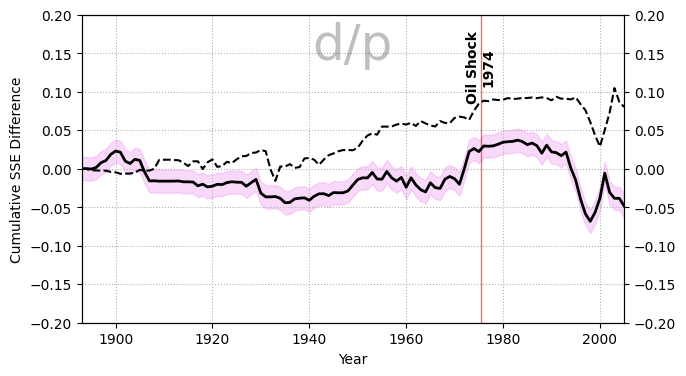

{'IS_error_N': yyyy
 1872-12-31    0.005812
 1873-12-31   -0.200410
 1874-12-31   -0.007187
 1875-12-31   -0.064107
 1876-12-31   -0.209425
                 ...   
 2000-12-31   -0.198178
 2001-12-31   -0.214177
 2002-12-31   -0.312477
 2003-12-31    0.191740
 2004-12-31    0.042687
 Freq: YE-DEC, Name: premium, Length: 133, dtype: float64,
 'IS_error_A': yyyy
 1872-12-31   -0.006216
 1873-12-31   -0.216160
 1874-12-31   -0.034353
 1875-12-31   -0.089958
 1876-12-31   -0.232471
                 ...   
 2000-12-31   -0.132897
 2001-12-31   -0.152891
 2002-12-31   -0.256424
 2003-12-31    0.233695
 2004-12-31    0.092288
 Freq: YE-DEC, Length: 133, dtype: float64,
 'OOS_error_N': array([-0.00506345,  0.01918719, -0.03084967,  0.12559369,  0.1710522 ,
         0.0547581 ,  0.12190932,  0.1314257 , -0.01002769, -0.22099831,
         0.21104629,  0.12323108, -0.0025057 , -0.41625418,  0.30371163,
         0.12134274, -0.14561176,  0.0010017 ,  0.01966741, -0.16722188,
        -0.0938639 ,  

In [7]:
# Selecting the Dividend Price Ratio (d/p) as the independent variable, and the equity premium as the dependent variable.
df = df[["d/p", "premium"]]

# running the model
get_statistics(df, "d/p", "premium")